# Importing libraries 

In [1]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

# Read Data

Time series deals with 2 columns, one is temporal ie: month in this case & another is the value to be forecasted ie: Quantity. 
To make plotting graphs easier, we set the index of pandas dataframe to the Month. During plots, 
the index will act by default as the x-axis & since it has only 1 more column, that will be automatically taken as the y-axis

In [2]:
df=pd.read_excel('F:\ML Internship\X.xlsx',parse_dates=['Post-Shipment Invoice Date'],index_col='Post-Shipment Invoice Date')

In [3]:
df.head()

,region,Customer Code,Technology,SAP Item Code,Qty(Net),SO Date,End Customer Code,plant
Post-Shipment Invoice Date,,,,,,,,
2015-12-08,reg_1,cc_1,t_1,sku_1,50.0,2015-12-07,ec_1,p1
2015-12-08,reg_2,cc_2,t_2,sku_2,15.0,2015-12-07,ec_2,p1
2015-11-23,reg_3,cc_3,t_2,sku_3,15.0,2015-12-09,ec_3,p2
2015-12-10,reg_3,cc_4,t_2,sku_3,30.0,2015-12-10,ec_4,p2
2015-12-03,reg_4,cc_5,t_3,sku_4,50.0,2015-12-09,ec_5,p2


In [4]:
df1=df.drop(['region','Customer Code','Technology','SAP Item Code','End Customer Code','plant','SO Date'],axis=1)

In [5]:

df1.head(14)

,Qty(Net)
Post-Shipment Invoice Date,
2015-12-08,50.0
2015-12-08,15.0
2015-11-23,15.0
2015-12-10,30.0
2015-12-03,50.0
2015-12-11,10.0
2015-12-11,20.0
2015-12-11,20.0
2015-12-11,15.0


In [6]:
df1=df1.rename(columns={'Qty(Net)':'Qty'})
df1.head()

,Qty
Post-Shipment Invoice Date,
2015-12-08,50.0
2015-12-08,15.0
2015-11-23,15.0
2015-12-10,30.0
2015-12-03,50.0


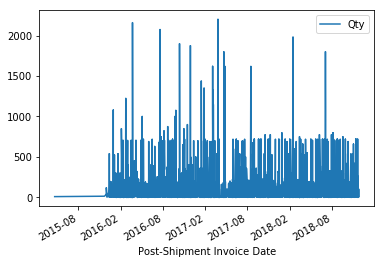

In [7]:
df1.plot()

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6566 entries, 2015-12-08 to 2018-10-17
Data columns (total 1 columns):
Qty    6566 non-null float64
dtypes: float64(1)
memory usage: 102.6 KB


In [9]:
df1=df1.resample('M').mean()
df1.head(10)
df1.dropna(inplace=True)

From the plot below, we can see that there is a no Trend compoenent in th series. 
Hence, we now check for stationarity of the data

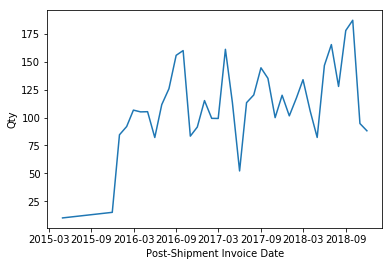

In [10]:
#plot graph 
plt.xlabel('Post-Shipment Invoice Date')
plt.ylabel('Qty')
plt.plot(df1)

In [11]:
#Determine rolling statistics
rolmean = df1.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = df1.rolling(window=12).std()
print(rolmean,rolstd)

                                   Qty
Post-Shipment Invoice Date            
2015-04-30                         NaN
2015-11-30                         NaN
2015-12-31                         NaN
2016-01-31                         NaN
2016-02-29                         NaN
2016-03-31                         NaN
2016-04-30                         NaN
2016-05-31                         NaN
2016-06-30                         NaN
2016-07-31                         NaN
2016-08-31                         NaN
2016-09-30                   96.215483
2016-10-31                  102.330868
2016-11-30                  108.708646
2016-12-31                  111.267067
2017-01-31                  111.877917
2017-02-28                  111.254086
2017-03-31                  115.932502
2017-04-30                  116.625538
2017-05-31                  114.125001
2017-06-30                  114.271543
2017-07-31                  113.803720
2017-08-31                  112.870797
2017-09-30               

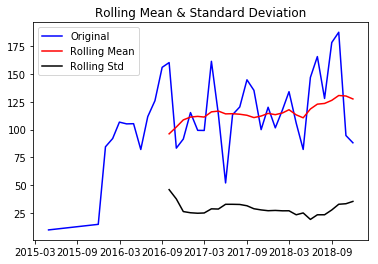

In [12]:
#Plot rolling statistics
orig = plt.plot(df1, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

rolling standard deviation is fairly constant with time. For our time series to be stationary, 
we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. 
Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so.

To further augment our hypothesis that the time series is not stationary, let us perform the ADCF test.

In [13]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df1['Qty'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -1.136683
p-value                         0.700224
#Lags Used                     10.000000
Number of Observations Used    27.000000
Critical Value (1%)            -3.699608
Critical Value (5%)            -2.976430
Critical Value (10%)           -2.627601
dtype: float64


For a Time series to be stationary, its ADCF test should have:

p-value to be low (according to the null hypothesis)
The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics
From the above ADCF test result, we see that p-value(0.70) is very large. 
Also critical values are no where close to the Test Statistics. Hence, we can safely say that 
our Time Series at the moment is not stationary

# Data Transformation to achieve Stationarity

There are a couple of ways to achieve stationarity through data transformation like taking  
log10log10 , logeloge , square, square root, cube, cube root, exponential decay, time shift and so on ...
lets start of with log transformations. Our objective is to  achieve stationarity. 


# Log Scale Tranformation 

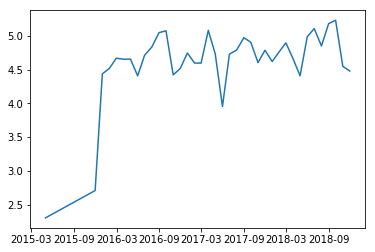

In [14]:
#Estimating trend
df1_logScale = np.log(df1)
plt.plot(df1_logScale)
df1.dropna(inplace=True)

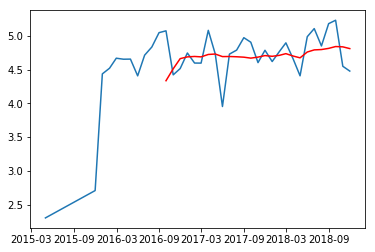

In [15]:
#The below transformation is required to make series stationary
movingAverage = df1_logScale.rolling(window=12).mean()
movingSTD = df1_logScale.rolling(window=12).std()
plt.plot(df1_logScale)
plt.plot(movingAverage, color='red')

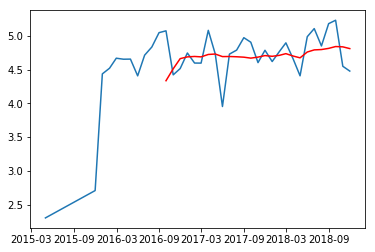

In [16]:
#The below transformation is required to make series stationary
movingAverage = df1_logScale.rolling(window=12).mean()
movingSTD = df1_logScale.rolling(window=12).std()
plt.plot(df1_logScale)
plt.plot(movingAverage, color='red')

From above graph, we see that even though rolling mean is not stationary, it is still better than the previous case

In [17]:
datasetLogScaleMinusMovingAverage = df1_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head()

,Qty
Post-Shipment Invoice Date,
2016-09-30,0.739621
2016-10-31,-0.089783
2016-11-30,-0.147265
2016-12-31,0.057701
2017-01-31,-0.097603


In [18]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Qty'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

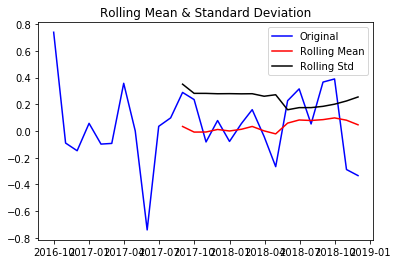

Results of Dickey Fuller Test:
Test Statistic                 -4.695780
p-value                         0.000086
#Lags Used                      1.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


In [19]:
test_stationarity(datasetLogScaleMinusMovingAverage)

From above graph, we observe that our intuition that 
"subtracting two related series having similar trend components will make the result stationary" is true. We find that:

p-value has reduced from 0.70 to 0.000086.
The critical values at 1%,5%,10% confidence intervals are pretty close to the Test Statistic. Thus, from above 2 points, we can say that our given series is stationary.
But, in the spirit of getting higher accuracy, let us explore & try to find a better scale than our current log.

Let us try out Exponential decay.


# Exponential Decay Transformation 

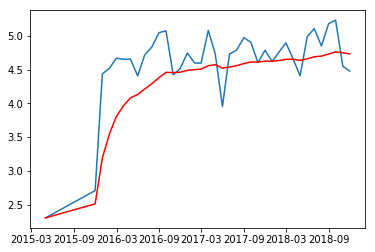

In [20]:
exponentialDecayWeightedAverage = df1_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(df1_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

From above graph, it seems that exponential decay is not holding any advantage over log scale as 
both the corresponding curves are similar. But, in statistics, inferences cannot be drawn simply by looking at the curves. 
Hence, we perform the ADCF test again on the decay series below.

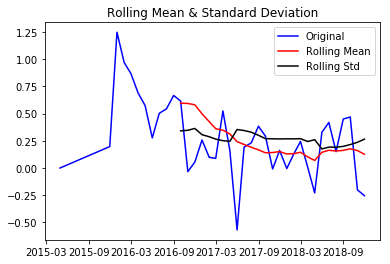

Results of Dickey Fuller Test:
Test Statistic                 -3.158592
p-value                         0.022510
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [21]:
datasetLogScaleMinusExponentialMovingAverage = df1_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

# Time Shift Transformation 

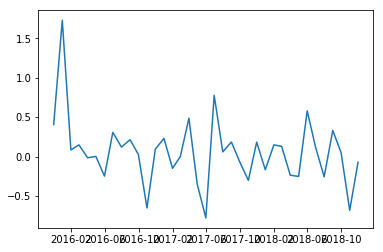

In [22]:
datasetLogDiffShifting = df1_logScale - df1_logScale.shift()
plt.plot(datasetLogDiffShifting)

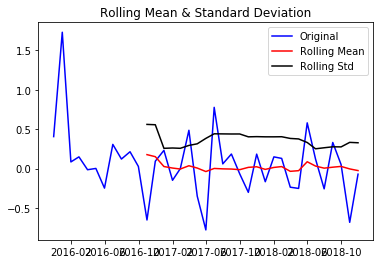

Results of Dickey Fuller Test:
Test Statistic                 -4.333035
p-value                         0.000389
#Lags Used                      5.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64


In [23]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

From above 2 graphs, we can see that, visually this is the best result as our series along with rolling statistic 
values of moving avg & moving std. dev. is very much flat & stationary. But, the ADCF test shows us that:

p-value of 0.0003 is  as good as 0.02 of exponential decay.
Test Statistic value not as close to the critical values as that for exponential decay.

We have thus tried out 3 different transformation: log, exp decay & time shift. For simplicity, we will go with the log scale. 
The reason for doing this is that we can revert back to the original scale during forecasting.

Let us now break down the 3 components of the log scale series using a system libary function. 
Once, we separate our the components, we can simply ignore trend & seasonality and check on the nature of the residual part.

C:\Users\Chess Master Darpan\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\Chess Master Darpan\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


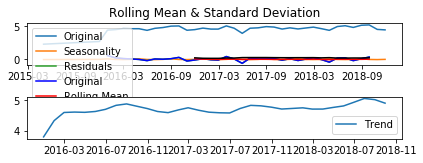

Results of Dickey Fuller Test:
Test Statistic                 -4.992754
p-value                         0.000023
#Lags Used                      5.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64


In [24]:
decomposition = seasonal_decompose(df1_logScale,freq=4) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df1_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

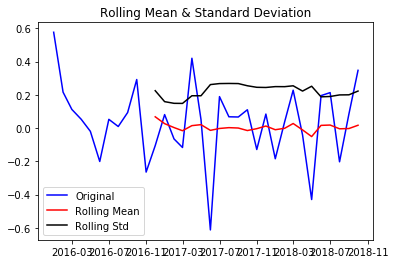

Results of Dickey Fuller Test:
Test Statistic                 -4.992754
p-value                         0.000023
#Lags Used                      5.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64


In [25]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

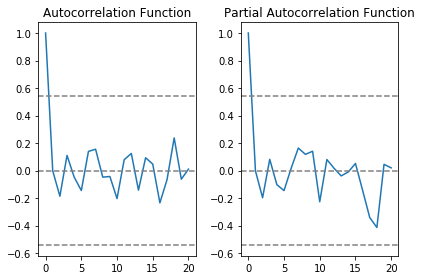

In [26]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.log(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.log(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.log(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.log(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()   

From the ACF graph, we see that curve touches y=0.0 line at x=2. 
Thus, from theory, Q = 2 From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. 
Note that, these models will give a value of RSS. Lower RSS values indicate a better model.

# Building Model

C:\Users\Chess Master Darpan\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Chess Master Darpan\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Plotting AR model


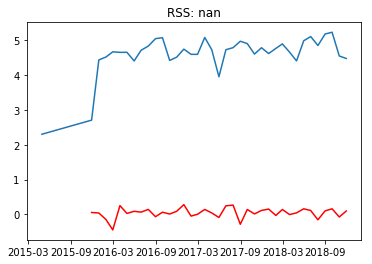

In [38]:
#AR Model
#making order=(1,1,0) gives RSS=6.5245
model = ARIMA(df1_logScale, order=(3,1,0))
results_AR = model.fit(disp=-1)
plt.plot(df1_logScale)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - df1_logScale['Qty'])**2))
print('Plotting AR model')

C:\Users\Chess Master Darpan\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Chess Master Darpan\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Plotting MA model


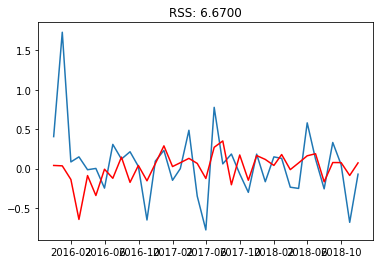

In [28]:
#MA Model
model = ARIMA(df1_logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['Qty'])**2))
print('Plotting MA model')

C:\Users\Chess Master Darpan\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Chess Master Darpan\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Plotting ARIMA model


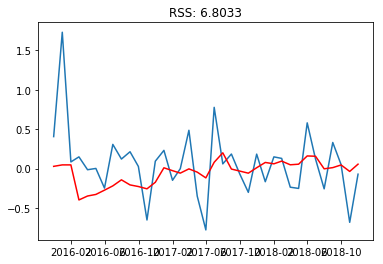

In [56]:
# AR+I+MA = ARIMA model
model = ARIMA(df1_logScale, order=(2,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['Qty'])**2))
print('Plotting ARIMA model')

In [30]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Post-Shipment Invoice Date
2015-11-30    0.030162
2015-12-31    0.027487
2016-01-31   -0.115983
2016-02-29   -0.526952
2016-03-31    0.094022
dtype: float64


In [31]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Post-Shipment Invoice Date
2015-11-30    0.030162
2015-12-31    0.057649
2016-01-31   -0.058334
2016-02-29   -0.585285
2016-03-31   -0.491264
2016-04-30   -0.781966
2016-05-31   -0.985875
2016-06-30   -1.192569
2016-07-31   -1.272239
2016-08-31   -1.557102
2016-09-30   -1.700509
2016-10-31   -1.928853
2016-11-30   -2.057310
2016-12-31   -1.939399
2017-01-31   -2.119154
2017-02-28   -2.195289
2017-03-31   -2.128498
2017-04-30   -2.187580
2017-05-31   -2.378669
2017-06-30   -2.173117
2017-07-31   -1.932905
2017-08-31   -2.234001
2017-09-30   -2.098402
2017-10-31   -2.164576
2017-11-30   -2.110521
2017-12-31   -2.001828
2018-01-31   -2.047794
2018-02-28   -1.894453
2018-03-31   -1.906604
2018-04-30   -1.851336
2018-05-31   -1.652125
2018-06-30   -1.508530
2018-07-31   -1.651325
2018-08-31   -1.537207
2018-09-30   -1.412469
2018-10-31   -1.541160
2018-11-30   -1.440657
dtype: float64


In [39]:
predictions_ARIMA_log = pd.Series(df1_logScale['Qty'].iloc[0], index=df1.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Post-Shipment Invoice Date
2015-04-30    2.302585
2015-11-30    2.332747
2015-12-31    2.360234
2016-01-31    2.244251
2016-02-29    1.717300
dtype: float64

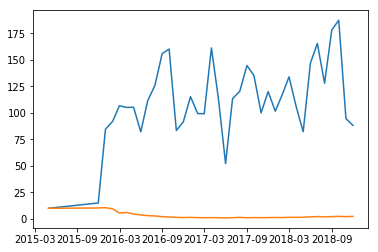

In [44]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df1)
plt.plot(predictions_ARIMA)

In [169]:
df1_logScale.shape

(38, 1)

In [43]:
from statsmodels.tsa.stattools import acf


In [60]:
# Create Training and Test
train = df1[:30]
test = df1[30:]

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6566 entries, 2015-12-08 to 2018-10-17
Data columns (total 8 columns):
region               6566 non-null object
Customer Code        6566 non-null object
Technology           6566 non-null object
SAP Item Code        6566 non-null object
Qty(Net)             6566 non-null float64
SO Date              6566 non-null datetime64[ns]
End Customer Code    6566 non-null object
plant                6566 non-null object
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 461.7+ KB


In [61]:
#You can now build the ARIMA model on training dataset, forecast and plot it.
# Build Model
# model = ARIMA(train, order=(3,2,1))
model = ARIMA(train, order=(1, 1, 1))
fitted = model.fit(disp=-1)

C:\Users\Chess Master Darpan\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Chess Master Darpan\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [62]:
# Forecast
fc, se, conf = fitted.forecast(8, alpha=0.05) # 95% conf

In [63]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

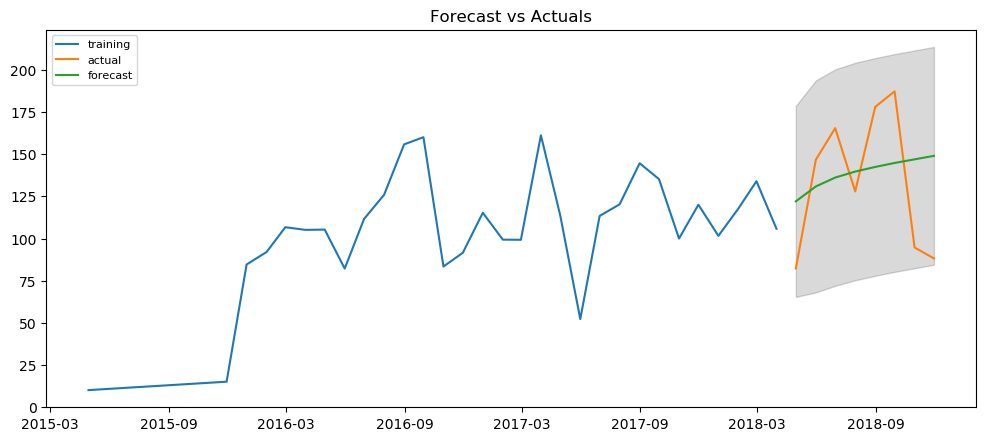

In [64]:




# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()